In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, dopioe, espra, smooth


In [2]:
def unit_det(Q, symmetrize=True):
    Q = np.asarray(Q, dtype=float)
    d = np.linalg.det(Q)
    if not np.isfinite(d) or d <= 0: raise ValueError("det(Q) must be positive and finite")
    s = 1/np.sqrt(d)
    return s*Q, s

def tangential_velocity(xp, yp, up, vp, xc, yc, Q, det1=False):
    Q = np.asarray(Q, float)
    if Q.shape == (3,):
        q11, q12, q22 = Q
        Q = np.array([[q11, q12], [q12, q22]], float)
    if det1:
        d = np.linalg.det(Q)
        if d != 0:
            Q /= np.sqrt(d)

    xp, yp, up, vp = (np.asarray(a, float) for a in (xp, yp, up, vp))
    r   = np.stack((xp - xc, yp - yc), axis=-1)
    g   = 2.0 * (r @ Q.T)                    # ∇F
    J   = np.array([[0., -1.], [1., 0.]])    # +90° rot
    tau = g @ J.T                             # tangent
    nrm = np.linalg.norm(tau, axis=-1, keepdims=True)
    t_hat = np.divide(tau, nrm, out=np.zeros_like(tau), where=nrm > 0)

    vel = np.stack((up, vp), axis=-1)
    vt  = np.sum(vel * t_hat, axis=-1)
    vt  = np.where(nrm.squeeze() > 0, vt, np.nan)
    return vt#, t_hat
    

In [3]:
x, y = np.linspace(-100, 100, 100), np.linspace(-100, 100, 100)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0, 0
Q11, Q12, Q22 = 1, 0.25, 1
psi0 = -100
Rc = 35
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                       'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

vt = (-2*psi0*np.sqrt(rho2)/Rc**2)*np.exp(-rho2/Rc**2)


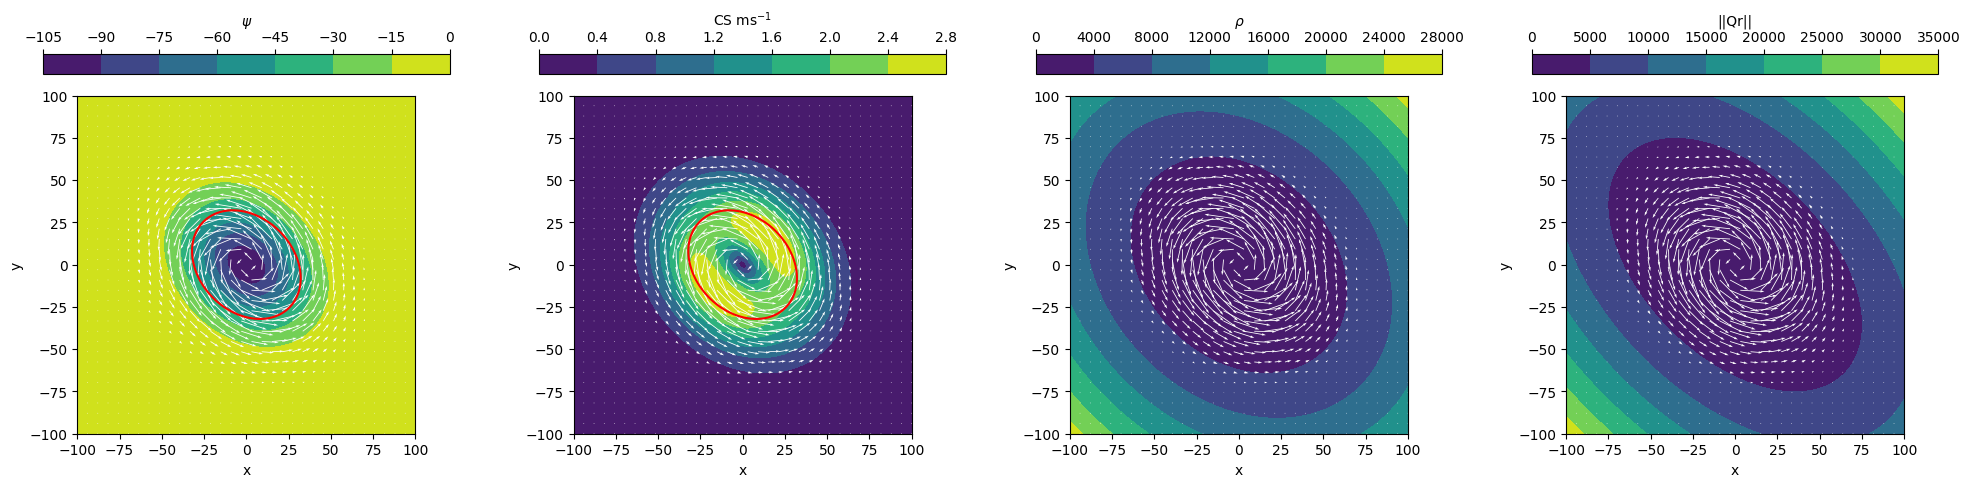

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

# First subplot
c0 = axs[0].contourf(X, Y, psi)
fig.colorbar(c0, ax=axs[0], label=r'$\psi$',
             orientation='horizontal', location='top')
spac = 3
axs[0].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[0].contour(X, Y, rho2, colors='r', levels=[1000], alpha=1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')

# Second subplot
c1 = axs[1].contourf(X, Y, np.hypot(u, v))
fig.colorbar(c1, ax=axs[1], label=r'CS ms$^{-1}$',
             orientation='horizontal', location='top')
axs[1].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[1].contour(X, Y, rho2, colors='r', levels=[1000], alpha=1)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')

c2 = axs[2].contourf(X, Y, rho2)
fig.colorbar(c2, ax=axs[2], label=r'$\rho$',
             orientation='horizontal', location='top')
axs[2].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal')

c3 = axs[3].contourf(X, Y, Qr2)
fig.colorbar(c3, ax=axs[3], label='||Qr||',
             orientation='horizontal', location='top')
axs[3].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].set_aspect('equal')

plt.tight_layout()
plt.show()


In [5]:
x0, y0 = 0, 0
r = 25
# nearest indices to (x0, y0)
i0 = np.argmin(np.abs(x - x0))
j0 = np.argmin(np.abs(y - y0)) 
# zonal transect at y = y0
mask_x = np.abs(x - x0) < r
x1, y1 = x[mask_x], np.full(np.sum(mask_x), y[j0])
u1, v1 = u[mask_x, j0], v[mask_x, j0]
# meridional transect at x = x0
mask_y = np.abs(y - y0) < r
x2, y2 = np.full(np.sum(mask_y), x[i0]), y[mask_y]
u2, v2 = u[i0, mask_y], v[i0, mask_y]

points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

xc_dop, yc_dop, w_dop, AQ_dop, *_ = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
A_dop = np.sqrt(np.linalg.det(AQ_dop)) # det(Q) = 1, A = -psi0/Rc**2
q11_dop, q12_dop, q22_dop = AQ_dop[0,0]/A_dop, AQ_dop[1,0]/A_dop, AQ_dop[1,1]/A_dop
Q_dop = np.array([[q11_dop, q12_dop], [q12_dop, q22_dop]])

dx_dop, dy_dop = xi - xc_dop, yi - yc_dop
rho2_dop = q11_dop*dx_dop**2 + 2*q12_dop*dx_dop*dy_dop + q22_dop*dy_dop**2
rho_dop = np.sqrt(rho2_dop)
Qr_dop = np.sqrt((q11_dop*dx_dop + q12_dop*dy_dop)**2
                  + (q12_dop*dx_dop + q22_dop*dy_dop)**2) #||Qr||
vt_dop = np.abs(tangential_velocity(xi, yi, ui, vi, xc_dop, yc_dop, Q_dop))
idx_max_vt = np.where(vt_dop==np.max(vt_dop))[0][0]
# Qr_dop_max = Qr_dop[idx_max_vt]
# Rc_dop = Qr_dop_max * np.sqrt(2) # Rc = rho_max * np.sqrt(2)
rho2_dop_max = Qr_dop[idx_max_vt]
Rc_dop = rho2_dop_max * np.sqrt(2) # Rc = rho_max * np.sqrt(2)
psi0_dop = - A_dop * Rc_dop**2 

df_res.loc[len(df_res)] = {'xc': xc_dop, 'yc': yc_dop, 'q11': q11_dop, 'q12': q12_dop, 'q22': q22_dop,
                           'Rc': Rc_dop, 'psi0': psi0_dop, 'A': A_dop}
df_res


,xc,yc,q11,q12,q22,Rc,psi0,A
0,0.000000,0.000000,1.032796,0.258199,1.032796,35.000000,-100.000000,0.081633
1,-0.003471,-0.003471,1.032776,0.258119,1.032776,35.708845,-101.586694,0.079668


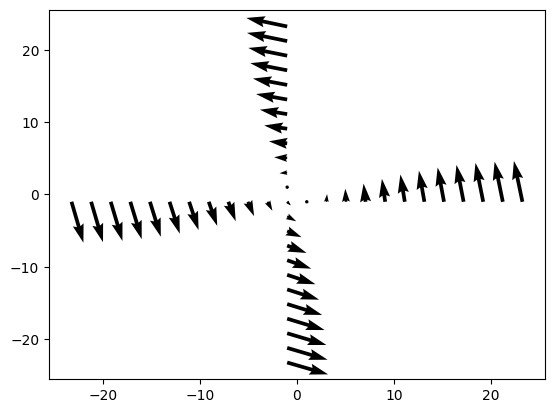

In [6]:
plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)


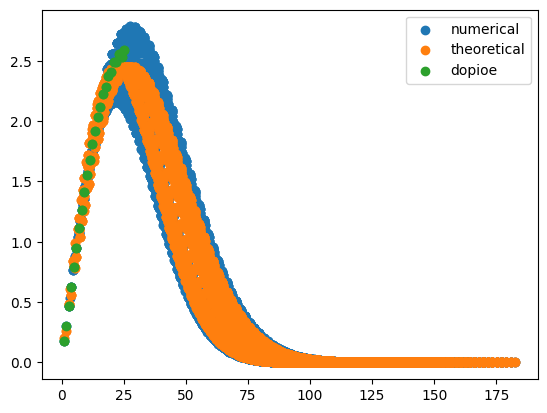

In [7]:
points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

vt_numerical = tangential_velocity(X.flatten(), Y.flatten(), u.flatten(), v.flatten(), xc, yc, Q)
plt.scatter(np.sqrt(Qr2), np.abs(vt_numerical), label='numerical') # Why does this not match the theoretical????

plt.scatter(np.sqrt(Qr2), np.abs(vt), label='theoretical')

plt.scatter(Qr_dop, np.abs(vt_dop), label='dopioe')

plt.legend()


### ROMS data

In [8]:
import pickle
df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')


In [9]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')
fnumber_old = 0


In [90]:
df_eddies[df_eddies.Eddy==474]


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname
19107,474,2902,AE,155.060611,-26.581985,99,300,261.917489,1484.839579,0.000025,0.006873,0.002849,0.005771,68.500213,-23.273701,62,1997-12-12,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
19108,474,2903,AE,155.085946,-26.683886,102,299,267.955926,1475.095789,0.000029,0.008288,0.003788,0.005997,75.750060,-22.847978,62,1997-12-13,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
19109,474,2904,AE,155.128600,-26.731705,104,298,273.672642,1471.563145,0.000029,0.008112,0.003701,0.006293,57.001556,-30.010703,62,1997-12-14,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
19110,474,2905,AE,155.121652,-26.774015,104,297,274.537607,1466.925320,0.000027,0.007372,0.003665,0.005944,68.751328,-76.332323,62,1997-12-15,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
19111,474,2906,AE,155.151116,-27.038827,109,292,286.772449,1440.359412,0.000025,0.006476,0.003294,0.006180,58.250839,-999999.975764,62,1997-12-16,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19164,474,2959,AE,154.726391,-31.296790,149,199,396.879488,982.343055,0.000032,0.011944,0.000721,0.004110,81.750631,-149.775521,62,1998-02-07,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
19165,474,2960,AE,154.705590,-31.214981,148,201,392.194736,990.211291,0.000032,0.012168,0.000512,0.003936,101.000290,-122.660823,62,1998-02-08,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
19166,474,2961,AE,154.643135,-31.293280,147,199,389.253942,980.008221,0.000031,0.011589,0.001145,0.003930,89.250597,-120.638176,62,1998-02-09,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
19167,474,2962,AE,154.580680,-31.371579,146,196,386.313148,969.805151,0.000030,0.011011,0.001777,0.003923,77.500904,-118.615530,62,1998-02-10,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [93]:
# eddy = 971
# day = 4550

eddy = 474
day = 2930

r = 100
data = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies['Day']==day)].iloc[0]
fname = data.fname
fnumber = fname[-8:-3]
if fnumber != fnumber_old:

    u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
    v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
    
    u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
    
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == day)[0][0]

u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

xc_surf, yc_surf = data.xc, data.yc
ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
X_mask, Y_mask = np.meshgrid(x_mask, y_mask)


(np.float64(294.1591054535873),
 np.float64(490.31410108234815),
 np.float64(1017.0678279040502),
 np.float64(1210.0499764751712))

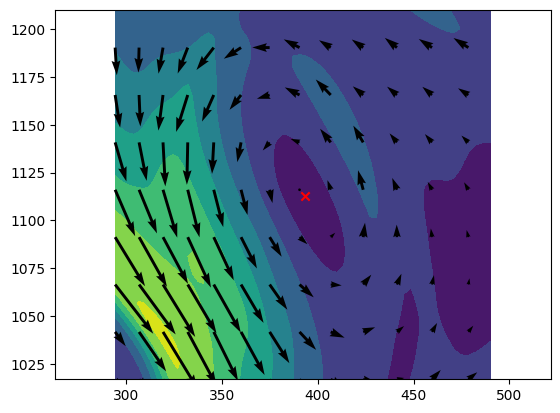

In [94]:
k = 0
plt.contourf(X_grid[X_mask, Y_mask], Y_grid[X_mask, Y_mask], np.hypot(u_t[X_mask, Y_mask,k], v_t[X_mask, Y_mask,k]))
spac = 5
plt.quiver(X_grid[X_mask[::spac, ::spac], Y_mask[::spac, ::spac]], Y_grid[X_mask[::spac, ::spac], Y_mask[::spac, ::spac]],
           u_t[X_mask[::spac, ::spac], Y_mask[::spac, ::spac],k], v_t[X_mask[::spac, ::spac], Y_mask[::spac, ::spac],k])
plt.scatter(data.xc, data.yc, marker='x', color='r')
plt.axis('equal')


In [95]:
X_local, Y_local = X_grid[X_mask, Y_mask], Y_grid[X_mask, Y_mask]
x_local, y_local = X_local[0,:], Y_local[:,0]
u_local, v_local = u_t[X_mask, Y_mask,k].T, v_t[X_mask, Y_mask,k].T


In [96]:
x0, y0 = xc_surf, yc_surf
r = 40

i0 = np.argmin(np.abs(x_local - x0))
j0 = np.argmin(np.abs(y_local - y0))

mask_x = np.abs(x_local - x0) < r
x1 = x_local[mask_x]
y1 = np.full(mask_x.sum(), y_local[j0])
u1 = u_local[mask_x, j0]
v1 = v_local[mask_x, j0]

mask_y = np.abs(y_local - y0) < r
x2 = np.full(mask_y.sum(), x_local[i0])
y2 = y_local[mask_y]
u2 = u_local[i0, mask_y]
v2 = v_local[i0, mask_y]


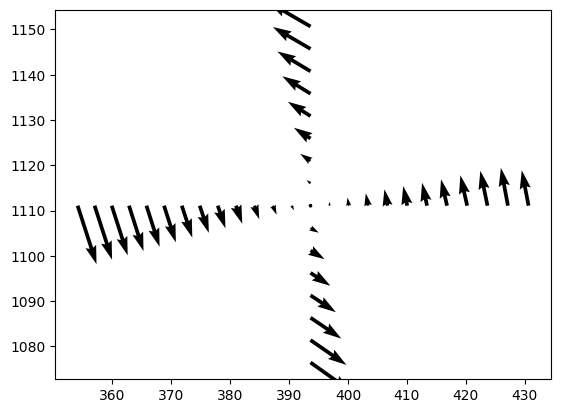

In [97]:
plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)


In [98]:
points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

xc_dop, yc_dop, w_dop, AQ_dop, *_ = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
A_dop = np.sqrt(np.linalg.det(AQ_dop)) # det(Q) = 1, A = -psi0/Rc**2
q11_dop, q12_dop, q22_dop = AQ_dop[0,0]/A_dop, AQ_dop[1,0]/A_dop, AQ_dop[1,1]/A_dop
Q_dop = np.array([[q11_dop, q12_dop], [q12_dop, q22_dop]])

dx_dop, dy_dop = xi - xc_dop, yi - yc_dop
rho2_dop = q11_dop*dx_dop**2 + 2*q12_dop*dx_dop*dy_dop + q22_dop*dy_dop**2
rho_dop = np.sqrt(rho2_dop)
# rho_dop = np.sqrt((q11_dop*dx_dop + q12_dop*dy_dop)**2
#                   + (q12_dop*dx_dop + q22_dop*dy_dop)**2) #||Qr||
vt_dop = np.abs(tangential_velocity(xi, yi, ui, vi, xc_dop, yc_dop, Q_dop))
idx_max_vt = np.where(vt_dop==np.max(vt_dop))[0][0]
rho_dop_max = rho_dop[idx_max_vt]
Rc_dop = rho_dop_max * np.sqrt(2) # Rc = rho_max * np.sqrt(2)
psi0_dop = - A_dop * Rc_dop**2 

df_res = pd.DataFrame({'xc': [xc_dop], 'yc': [yc_dop], 'q11': [q11_dop], 'q12': [q12_dop], 'q22': [q22_dop],
                            'Rc': [Rc_dop], 'psi0': [psi0_dop], 'A': [A_dop]})
df_res


,xc,yc,q11,q12,q22,Rc,psi0,A
0,393.321138,1112.799613,1.598197,0.498485,0.781184,71.075397,-30.3902,0.006016


In [99]:
data = df_res.iloc[0]

dx, dy = X_local - data.xc, Y_local - data.yc
rho2 = data.q11*dx**2 + 2*data.q12*dx*dy + data.q22*dy**2
# rho2 = (data.q11*dx + data.q12*dy)**2 + (data.q12*dx + data.q22*dy)**2 # ||Qr||

psi = data.psi0 * np.exp( - rho2 / data.Rc**2 )
u_dop =   data.psi0 * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q12*dx + 2*data.q22*dy ) / data.Rc**2
v_dop = - data.psi0 * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q11*dx + 2*data.q12*dy ) / data.Rc**2


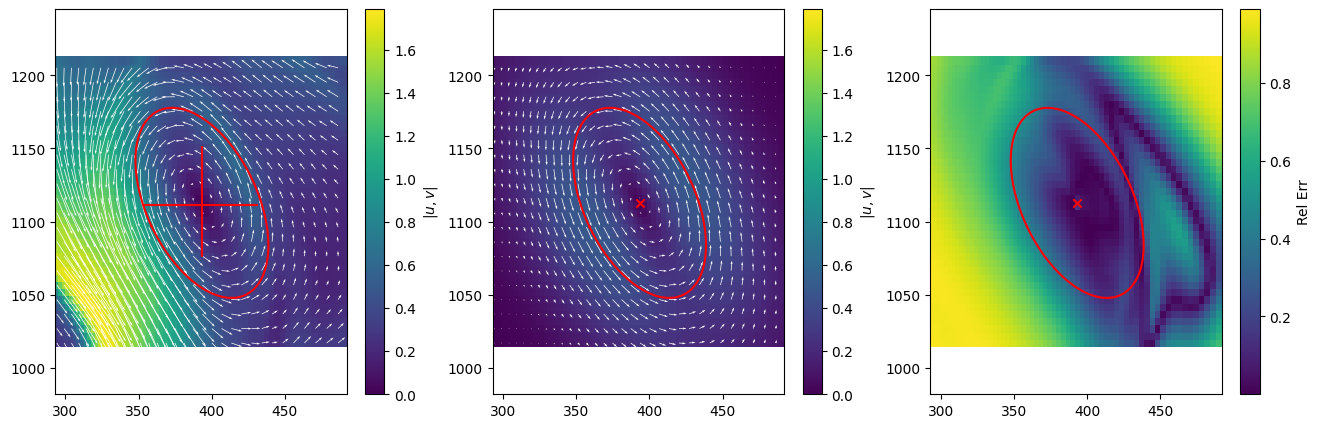

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))

vmax = np.max([np.hypot(u_local, v_local).max(),
               np.hypot(u_dop, v_dop).max()])

c0 = axs[0].pcolor(X_local, Y_local, np.hypot(u_local, v_local).T,
                     vmin=0, vmax=vmax)
spac = 2
axs[0].quiver(X_local[::spac, ::spac], Y_local[::spac, ::spac],
              u_local[::spac, ::spac].T, v_local[::spac, ::spac].T,
              scale=10, color='w')
axs[0].plot(x1, y1, color='r'); axs[0].plot(x2, y2, color='r')
x_ell, y_ell = plot_ellipse(np.array([[data.q11, data.q12],
                                      [data.q12, data.q22]]),
                            center=(data.xc, data.yc), scale=data.Rc)
axs[0].plot(x_ell, y_ell, color='r')
axs[0].axis('equal')
fig.colorbar(c0, ax=axs[0], orientation='vertical', label=r'$|u,v|$')

c1 = axs[1].pcolor(X_local, Y_local, np.hypot(u_dop, v_dop),
                     vmin=0, vmax=vmax)
axs[1].quiver(X_local[::spac, ::spac], Y_local[::spac, ::spac],
              u_dop[::spac, ::spac], v_dop[::spac, ::spac],
              scale=10, color='w')
axs[1].scatter(data.xc, data.yc, marker='x', color='r')
axs[1].plot(x_ell, y_ell, color='r')
axs[1].axis('equal')
fig.colorbar(c1, ax=axs[1], orientation='vertical', label=r'$|u,v|$')


speed_obs = np.hypot(u_local, v_local).T
speed_mod = np.hypot(u_dop, v_dop)
rel_err = np.abs(speed_obs - speed_mod) / speed_obs
c2 = axs[2].pcolor(X_local, Y_local, rel_err)
fig.colorbar(c2, ax=axs[2], orientation='vertical', label=r'Rel Err')
axs[2].scatter(data.xc, data.yc, marker='x', color='r')
axs[2].plot(x_ell, y_ell, color='r')
axs[2].axis('equal')

plt.show()


In [ ]:
speed_obs = np.hypot(df_app_moca.u, df_app_moca.v)
speed_mod = np.hypot(df_app_moca.u_esp, df_app_moca.v_esp)

df_app_moca.loc[:, 'err'] = np.abs(speed_obs - speed_mod) / speed_obs

### ESPRA

In [ ]:
break

In [19]:
def dop_params(AQ, xi, yi, ui, vi, xc, yc, tangential_velocity):
    A = np.sqrt(np.linalg.det(AQ))
    q11, q12, q22 = AQ[0,0]/A, AQ[1,0]/A, AQ[1,1]/A
    Q = np.array([[q11,q12],[q12,q22]])
    dx, dy = xi-xc, yi-yc
    # rho = np.sqrt((q11*dx+q12*dy)**2+(q12*dx+q22*dy)**2)
    rho = np.sqrt(q11_dop*dx_dop**2 + 2*q12_dop*dx_dop*dy_dop + q22_dop*dy_dop**2)
    vt = np.abs(tangential_velocity(xi, yi, ui, vi, xc, yc, Q))
    Rc = rho[np.argmax(vt)]*np.sqrt(2)
    psi0 = -A*Rc**2
    return Rc, psi0, Q
    

#### Drifter Data

In [20]:
from datetime import datetime

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)

drifter_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/CCE_2023_6h.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
ID_drif =  drifter_dataset['ID'][:]
secs = drifter_dataset['time'][:].data
tim_drif = [datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S') for t in secs]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters[np.hypot(df_drifters.u, df_drifters.v) < 100]
df_drifters = df_drifters.reset_index().drop(columns=['index'])
df_drifters = df_drifters[df_drifters.Time < pd.Timestamp('2024-02-10 00:00:00')]
df_drifters.head()


,ID,Lon,Lat,u,v,Time
0,300534062034380,153.975,-37.651,0.003961,0.004561,2023-10-19 12:00:00
1,300534062034380,154.095,-37.579,0.004713,0.003265,2023-10-19 18:00:00
2,300534062034380,154.206,-37.523,0.004703,0.001505,2023-10-20 00:00:00
3,300534062034380,154.325,-37.520,0.004957,-0.000603,2023-10-20 06:00:00
4,300534062034380,154.448,-37.547,0.004584,-0.001956,2023-10-20 12:00:00


#### IMOS Data

In [21]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}
    

In [58]:
start = df_drifters.Time.min() + pd.Timedelta(days=1)
end   = df_drifters.Time.max() - pd.Timedelta(days=1)
times = pd.date_range(start, end, freq='D')

results = []

rs = []
v_thetas = []
for t in times:
    mask = df_drifters.Time.between(t - pd.Timedelta(days=1),
                                     t + pd.Timedelta(days=1))
    xi, yi = df_drifters.loc[mask, ['Lon', 'Lat']].values.T
    ui, vi = df_drifters.loc[mask, ['u',   'v'  ]].values.T
    xc_esp, yc_esp, w_esp, AQ_esp, *_ = espra(xi, yi, ui, vi) 
    w_esp /= deg_to_m(np.mean(yi))


    A_esp = np.sqrt(np.linalg.det(AQ_esp)) # det(Q) = 1, A = -psi0/Rc**2
    q11_esp, q12_esp, q22_esp = AQ_esp[0,0]/A_esp, AQ_esp[1,0]/A_esp, AQ_esp[1,1]/A_esp
    Q_esp = np.array([[q11_esp, q12_esp], [q12_esp, q22_esp]])
    
    dx_esp, dy_esp = xi - xc_esp, yi - yc_esp
    rho2_esp = q11_esp*dx_esp**2 + 2*q12_esp*dx_esp*dy_esp + q22_esp*dy_esp**2
    rho_esp = np.sqrt(rho2_esp)
    # rho_esp = np.sqrt((q11_esp*dx_esp + q12_esp*dy_esp)**2
    #                   + (q12_esp*dx_esp + q22_esp*dy_esp)**2) #||Qr||
    vt_esp = np.abs(tangential_velocity(xi, yi, ui, vi, xc_esp, yc_esp, Q_esp))
    idx_max_vt = np.where(vt_esp==np.max(vt_esp))[0][0]
    rho_esp_max = rho_esp[idx_max_vt]
    Rc_esp = rho_esp_max * np.sqrt(2) # Rc = rho_max * np.sqrt(2)
    psi0_esp = - A_esp * Rc_esp**2 

    # Rc_esp, psi0_esp, Q_esp = dop_params(AQ_esp, xi, yi, ui, vi,
    #                          xc_esp, yc_esp, tangential_velocity)

    results.append(dict(xc=xc_esp, yc=yc_esp, w=w_esp,
                        q11=Q_esp[0,0], q12=Q_esp[1,0], q22=Q_esp[1,1],
                        Rc=Rc_esp, psi0=psi0_esp, Time=t))

df_results = pd.DataFrame(results)
df_results


,xc,yc,w,q11,q12,q22,Rc,psi0,Time
0,154.267637,-37.953826,-1.835220e-07,1.130276,0.102656,0.894063,0.661867,-0.002816,2023-10-20 12:00:00
1,154.321904,-37.919899,-2.089448e-07,1.180300,0.046509,0.849075,0.549307,-0.002200,2023-10-21 12:00:00
2,154.235778,-37.942048,-2.148768e-07,0.939455,0.051388,1.067258,0.590595,-0.002643,2023-10-22 12:00:00
3,154.169484,-37.965548,-2.316670e-07,0.909202,0.121553,1.116116,0.527249,-0.002251,2023-10-23 12:00:00
4,154.153028,-37.911515,-2.248849e-07,0.952993,0.044465,1.051401,0.571303,-0.002594,2023-10-24 12:00:00
...,...,...,...,...,...,...,...,...,...
107,150.676653,-37.187982,-2.496089e-07,1.031158,0.250171,1.030478,0.360806,-0.001120,2024-02-04 12:00:00
108,150.654736,-37.237212,-2.727406e-07,0.852219,0.275944,1.262756,0.334079,-0.001022,2024-02-05 12:00:00
109,150.705005,-37.318210,-2.489821e-07,0.640753,0.184493,1.613785,0.285161,-0.000638,2024-02-06 12:00:00
110,150.685157,-37.294499,-3.073088e-07,0.556426,0.259359,1.918075,0.319506,-0.000901,2024-02-07 12:00:00


,xc,yc,w,q11,q12,q22,Rc,psi0,Time,sRc,spsi0
0,154.267637,-37.953826,-1.835220e-07,1.130276,0.102656,0.894063,0.661867,-0.002816,2023-10-20 12:00:00,0.551106,-0.002221
1,154.321904,-37.919899,-2.089448e-07,1.180300,0.046509,0.849075,0.549307,-0.002200,2023-10-21 12:00:00,0.542218,-0.002181
2,154.235778,-37.942048,-2.148768e-07,0.939455,0.051388,1.067258,0.590595,-0.002643,2023-10-22 12:00:00,0.528119,-0.002107
3,154.169484,-37.965548,-2.316670e-07,0.909202,0.121553,1.116116,0.527249,-0.002251,2023-10-23 12:00:00,0.525790,-0.002119
4,154.153028,-37.911515,-2.248849e-07,0.952993,0.044465,1.051401,0.571303,-0.002594,2023-10-24 12:00:00,0.522962,-0.002129
...,...,...,...,...,...,...,...,...,...,...,...
107,150.676653,-37.187982,-2.496089e-07,1.031158,0.250171,1.030478,0.360806,-0.001120,2024-02-04 12:00:00,0.351486,-0.001119
108,150.654736,-37.237212,-2.727406e-07,0.852219,0.275944,1.262756,0.334079,-0.001022,2024-02-05 12:00:00,0.357500,-0.001158
109,150.705005,-37.318210,-2.489821e-07,0.640753,0.184493,1.613785,0.285161,-0.000638,2024-02-06 12:00:00,0.360865,-0.001181
110,150.685157,-37.294499,-3.073088e-07,0.556426,0.259359,1.918075,0.319506,-0.000901,2024-02-07 12:00:00,0.355747,-0.001158


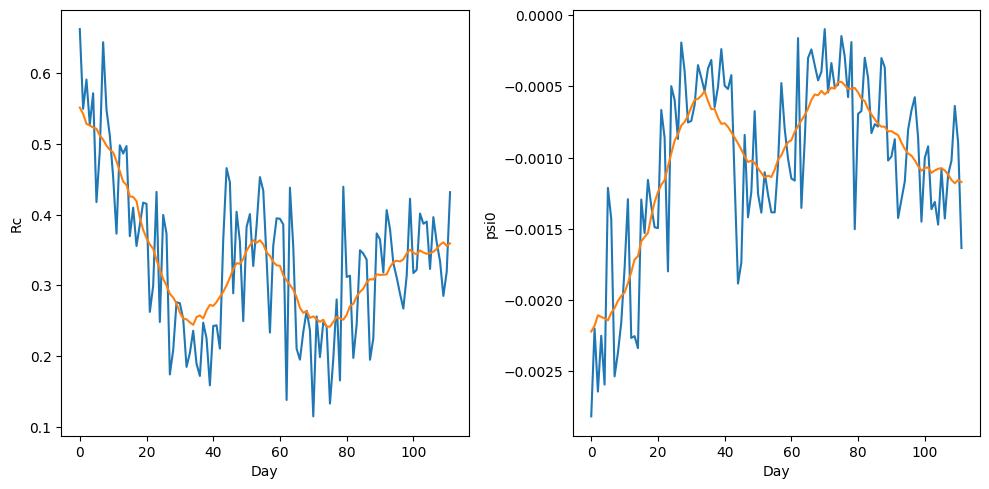

In [59]:
wdw = 20
df_results['sRc'] = smooth(df_results.Rc, np.arange(len(df_results)), num=len(df_results), window=wdw)
df_results['spsi0'] = smooth(df_results.psi0, np.arange(len(df_results)), num=len(df_results), window=wdw)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(df_results.Rc)
axs[0].plot(df_results.sRc)
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Rc')
axs[1].plot(df_results.psi0)
axs[1].plot(df_results.spsi0)
axs[1].set_xlabel('Day')
axs[1].set_ylabel('psi0')
plt.tight_layout()

df_results


In [60]:
X_local, Y_local = np.meshgrid(np.linspace(150.5, 155, 50),
                               np.linspace(-35.5, -39.5, 50))


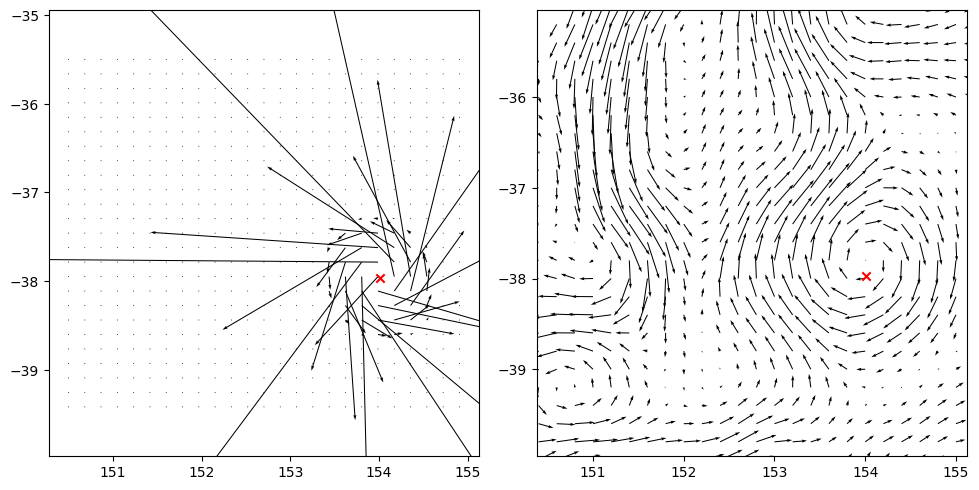

In [61]:
data = df_results.iloc[30]

dx, dy = X_local - data.xc, Y_local - data.yc
rho2 = data.q11*dx**2 + 2*data.q12*dx*dy + data.q22*dy**2

psi = data.spsi0 * np.exp( - rho2 / data.sRc**2 )
u_dop =   data.spsi0 * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.q12*dx + 2*data.q22*dy ) / data.sRc**2
v_dop = - data.spsi0 * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.q11*dx + 2*data.q12*dy ) / data.sRc**2


fig, axs = plt.subplots(1, 2, figsize=(10,5))
spac = 2
axs[0].quiver(X_local[::spac, ::spac], Y_local[::spac, ::spac],
           u_dop[::spac, ::spac], v_dop[::spac, ::spac])#, scale=10)
axs[0].scatter(data.xc, data.yc, color='r', marker='x')
axs[0].axis('equal')

t = data.Time
closest = min(tim_ssh, key=lambda tt: abs(tt - t))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
axs[1].quiver(lon_ssh, lat_ssh, ut, vt, scale=10)
axs[1].scatter(data.xc, data.yc, color='r', marker='x')
axs[1].axis('equal')
axs[1].set_xlim(X_local.min(), X_local.max())
axs[1].set_ylim(Y_local.min(), Y_local.max())

plt.tight_layout()


In [53]:
u_dop.max()


np.float64(0.002205082445692225)